# Case de Telemedicina e Data Science - Estudo NPS
Este notebook tem o objetivo de analisar a base de clientes e propor ações para aumentar o tempo que o usuário permanece sendo assinante do serviço.

## Ideias
- NPS por canal 
- Análise cohort
- Sazonalidade de consultas em cada canal
- Modelar algoritmo de sobrevivencia para prever o tempo de aderencia de um usuario
- Criar algoritmo baseado na idade, cidade e genero para recomendar canal de consulta

## Hipóteses
- A primeira impressão é a que fica: NPS de usuarios que fizeram apenas uma consulta é menor

## Base de dados

In [1]:
import pandas as pd
import numpy as np

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%y')
appointments = pd.read_csv('dataset/appointments.csv'
                           ,parse_dates = ['appointment_date']
                           ,date_parser = dateparse)
appointments.head()

/Users/victordesanunes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,appt_id,user_id,appointment_date,channel,type
0,1,1,2010-08-10,chat,first
1,2,1,2010-10-29,chat,regular
2,3,2,2011-06-18,presential,first
3,4,2,2011-10-24,chat,regular
4,5,2,2011-12-29,chat,regular


In [3]:
appointments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2690 entries, 0 to 2689
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   appt_id           2690 non-null   int64         
 1   user_id           2690 non-null   int64         
 2   appointment_date  2690 non-null   datetime64[ns]
 3   channel           2690 non-null   object        
 4   type              2690 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 105.2+ KB


In [4]:
users = pd.read_csv('dataset/users.csv'
                           ,parse_dates = ['birth_date', 'start_date', 'end_date']
                           ,date_parser = dateparse)
users.head()

/Users/victordesanunes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,user_id,gender,birth_date,start_date,end_date,city_code
0,1,female,1981-07-07,2010-06-29,2010-11-02,3
1,2,male,1996-10-08,2011-01-18,2012-02-18,1
2,3,female,1986-06-03,2010-01-13,2010-09-12,3
3,4,male,1992-07-28,2010-11-19,2012-08-01,3
4,5,male,1981-04-21,2011-08-27,2011-12-11,2


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     463 non-null    int64         
 1   gender      463 non-null    object        
 2   birth_date  463 non-null    datetime64[ns]
 3   start_date  463 non-null    datetime64[ns]
 4   end_date    463 non-null    datetime64[ns]
 5   city_code   463 non-null    int64         
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 21.8+ KB


In [6]:
nps = pd.read_csv('dataset/nps.csv')
nps.head()

,user_id,nps
0,1,9
1,2,5
2,3,5
3,4,10
4,5,8


In [7]:
nps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  463 non-null    int64
 1   nps      463 non-null    int64
dtypes: int64(2)
memory usage: 7.4 KB


## NPS
Cálculo do NPS geral da Cuidas. 
O NPS é a nota referente a ultima consulta do usuario. Portanto vamos separa os dados da ultima consulta de cada usuario em um dataframe

In [8]:
last_appointment_ids = appointments.groupby(by='user_id').agg({'appt_id': 'max'})['appt_id'].tolist()
last_appointment = appointments[appointments['appt_id'].isin(last_appointment_ids)]
last_appointment_and_nps = last_appointment.merge(nps)
# last_appointment_and_nps.sort_values(by = 'appointment_date', inplace = True)
last_appointment_and_nps.head(10)

,appt_id,user_id,appointment_date,channel,type,nps
0,2,1,2010-10-29,chat,regular,9
1,9,2,2011-07-06,presential,regular,5
2,13,3,2010-04-07,chat,regular,5
3,21,4,2011-11-17,presential,regular,10
4,22,5,2011-11-10,chat,first,8
5,28,6,2011-07-12,chat,regular,2
6,30,7,2010-10-10,chat,regular,4
7,39,8,2011-11-21,chat,regular,9
8,40,9,2011-10-24,presential,first,7
9,49,10,2012-02-21,chat,regular,3


In [9]:
nps_scores = last_appointment_and_nps['nps'].tolist()
def calculate_nps(nps_scores):  
    valid_scores = [v for v in nps_scores if v >= 0 and v <= 10]
    promoters = [s for s in valid_scores if s >=9 and s <= 10]
    detractors = [s for s in valid_scores if s >= 0 and s <= 6]
    nps_score = (float(len(promoters) - len(detractors)) / len (valid_scores)) * 100.0
    return nps_score, detractors, promoters

cuidas_nps, detractors, promoters = calculate_nps(nps_scores)
cuidas_nps

-14.038876889848812

**Margem de erro**: assumindo que a nota média de NPS da cuidas é de 6

- [referencia](https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/margin-of-error/)
- [calculando t score](https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f)

In [10]:
# margem de erro
sample_std = np.std(nps_scores)
population_mean = 6.0
sample_mean = np.mean(nps_scores)
sample_size = len(nps_scores)
t_score = (sample_mean - population_mean)/(sample_std/np.sqrt(sample_size))
t_score

3.8869838153218392

In [11]:
margin_of_error = t_score * sample_std
margin_of_error

10.2242670714838

Como o NPS da Cuidas está muito baixo, iremos entender melhor quais canais de antendimento precisam melhorar

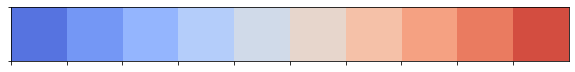

In [12]:
import seaborn as sns
sns.palplot(sns.color_palette("coolwarm", 10))

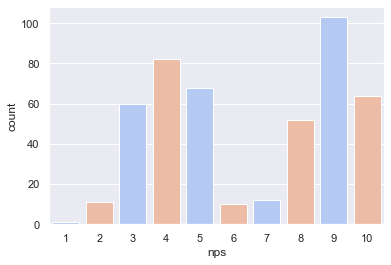

In [13]:
sns.set(style="darkgrid")
# sns.set_palette(palette = sns.color_palette("coolwarm", 7))
sns.despine()
ax = sns.countplot(x="nps", data=last_appointment_and_nps, palette = sns.color_palette("coolwarm", 2))

In [14]:
import numpy as np
print('Nota media dos promoteres: ' + str(np.mean(promoters)))
print('Nota media dos detratores: ' + str(np.mean(detractors)))

Nota media dos promoteres: 9.383233532934131
Nota media dos detratores: 4.012931034482759


## NPS por canal

Vamos analisar os NPS de cada canal de atendimento

In [15]:
chat_channel = last_appointment_and_nps.query('channel == "chat"')
presential_channel = last_appointment_and_nps.query('channel == "presential"')

In [16]:
nps_scores = chat_channel['nps'].tolist()
chat_nps, detractor, promoters = calculate_nps(nps_scores)
chat_nps

-15.223880597014924

In [17]:
nps_scores = presential_channel['nps'].tolist()
presential, detractor, promoters = calculate_nps(nps_scores)
presential

-10.9375

># 💡O atendimento pelo chat está com NPS baixo

Porém em quais regiões o atendimento presencial é melhor?

## NPS de pessoas que tiveram apenas uma impresssao da empresa

Vamos analisar os usuarios que tiveram atendimento por apenas um canal ao longo de todo o seu histórico

In [18]:
appointments_user = appointments.merge(nps)[['appt_id', 'user_id', 'channel', 'type', 'nps']]

# Calcula estatisticas dos usuarios
length = lambda x: len(x.unique())
user_stats = appointments_user.groupby(by = ['user_id']).agg({'appt_id': 'count'
                                                                ,'type': 'unique'
                                                                ,'nps': 'mean'
                                                                ,'type': length
                                                                ,'channel': length})\
                                                        .rename({'appt_id': 'total_appt'
                                                                ,'type': 'total_type'
                                                                ,'channel': 'total_channel'}, axis = 1)
user_stats.head()

,total_appt,total_type,nps,total_channel
user_id,,,,
1,2,2,9,1
2,7,2,5,2
3,4,2,5,1
4,8,2,10,2
5,1,1,8,1


In [19]:
one_channel_users = user_stats.query('total_channel == 1').index
nps_scores = last_appointment_and_nps[last_appointment_and_nps['user_id'].isin(one_channel_users)]['nps'].tolist()
one_channel_nps, detractor, promoters = calculate_nps(nps_scores)
one_channel_nps
print('NPS: ' + str(one_channel_nps))
print('Nota media dos promoteres: ' + str(np.mean(promoters)))
print('Nota media dos detratores: ' + str(np.mean(detractors)))

NPS: -15.168539325842698
Nota media dos promoteres: 9.333333333333334
Nota media dos detratores: 4.012931034482759


In [20]:
two_channel_users = user_stats.query('total_channel == 2').index
nps_scores = last_appointment_and_nps[last_appointment_and_nps['user_id'].isin(two_channel_users)]['nps'].tolist()
two_channel_nps, detractor, promoters = calculate_nps(nps_scores)
print('NPS: ' + str(two_channel_nps))
print('Nota media dos promoteres: ' + str(np.mean(promoters)))
print('Nota media dos detratores: ' + str(np.mean(detractors)))

NPS: -13.333333333333334
Nota media dos promoteres: 9.413461538461538
Nota media dos detratores: 4.012931034482759


># 💡Usuarios que foram atendidos por apenas um canal, tiveram uma experiencia melhor

## NPS para usuarios que fizeram apenas uma consulta

In [21]:
first_appointment = last_appointment_and_nps.query('type == "first"')
nps_scores = first_appointment['nps'].tolist()
first_appointment_nps, detractor, promoters = calculate_nps(nps_scores)
print('NPS: ' + str(first_appointment_nps))
print('Nota media dos promoteres: ' + str(np.mean(promoters)))
print('Nota media dos detratores: ' + str(np.mean(detractors)))

NPS: -13.186813186813188
Nota media dos promoteres: 9.242424242424242
Nota media dos detratores: 4.012931034482759


In [22]:
regular_appointment = last_appointment_and_nps.query('type == "regular"')
nps_scores = regular_appointment['nps'].tolist()
regular_appointment_nps, detractor, promoters = calculate_nps(nps_scores)

print('NPS: ' + str(regular_appointment_nps))
print('Nota media dos promoteres: ' + str(np.mean(promoters)))
print('Nota media dos detratores: ' + str(np.mean(detractors)))

NPS: -14.24731182795699
Nota media dos promoteres: 9.417910447761194
Nota media dos detratores: 4.012931034482759


## Evolução do NPS ao longo do tempo
- Veremos a evolução do NPS para usuarios `first` e `regular`

In [23]:
import datetime as dt
last_appointment_and_nps.loc[:,'month_year'] = last_appointment_and_nps["appointment_date"].dt.strftime("%Y-%m")
regular_appointment.loc[:,'month_year'] = regular_appointment["appointment_date"].dt.strftime("%Y-%m")
first_appointment.loc[:,'month_year'] = first_appointment["appointment_date"].dt.strftime("%Y-%m")

last_appointment_and_nps.head()

/Users/victordesanunes/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/victordesanunes/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,appt_id,user_id,appointment_date,channel,type,nps,month_year
0,2,1,2010-10-29,chat,regular,9,2010-10
1,9,2,2011-07-06,presential,regular,5,2011-07
2,13,3,2010-04-07,chat,regular,5,2010-04
3,21,4,2011-11-17,presential,regular,10,2011-11
4,22,5,2011-11-10,chat,first,8,2011-11


In [24]:
def nps_score_per_period(serie):
    valid_scores = [v for v in serie if v >= 0 and v <= 10]
    promoters = [s for s in valid_scores if s >= 9 and s <= 10]
    detractors = [s for s in valid_scores if s >= 0 and s <= 6]
    nps_score = (float(len(promoters) - len(detractors)) / len (valid_scores)) * 100.0
    return nps_score

In [25]:
first_appt_nps_timeseries = first_appointment.groupby(by=['month_year']).agg({'nps': nps_score_per_period})
first_appt_nps_timeseries.head()

,nps
month_year,
2010-02,0.0
2010-03,-20.0
2010-04,0.0
2010-05,-100.0
2010-06,0.0


In [26]:
regular_appt_nps_timeseries = regular_appointment.groupby(by=['month_year']).agg({'nps': nps_score_per_period})
regular_appt_nps_timeseries.head()

,nps
month_year,
2010-01,-100.000000
2010-02,-100.000000
2010-03,-33.333333
2010-04,0.000000
2010-05,-30.000000
